Ye-seul Oh.

# <span style="color:blue">14주차(2) Random Forest - Regression</span>

Random Forest를 이용해서 실제 biological data를 가지고 prediction 해보기.  
여러가지 분자들을 JAK2단백질에 넣고 측정한 pIC50값을 가지고, 그 데이터를 얼마나 정확하게 예측할 수 있는지 살펴봄.

# Predicting activity of JAK2 inhibitors
## Goal of the class
* Practice the **regression model** using biological data <---(classification,**regression:어떤 숫자를 예측**,cluster)

## Janus kinase
Janus kinase (JAK) is a family of intracellular, non-receptor tyrosine kinases that transduce cytokine-mediated signals via the JAK-STAT pathway. They were initially named "just another kinase" 1 and 2 (since they were just two of many discoveries in a PCR-based screen of kinases),[1] but were ultimately published as "Janus kinase". The name is taken from the two-faced Roman god of beginnings, endings and duality, Janus, because the JAKs possess two near-identical phosphate-transferring domains. One domain exhibits the kinase activity, while the other negatively regulates the kinase activity of the first.

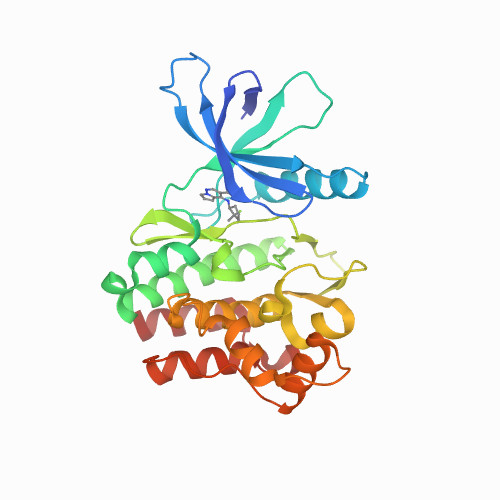

## IC50 
주어진 단백질 중에서 50%를 inactive하게 만드는 약의 농도. (IC50값이 작을수록, 즉 약의 농도가 작을 수록 effective한 약)  
The **half maximal inhibitory concentration (IC50)** is a measure of the potency of a substance in inhibiting a specific biological or biochemical function. 

IC50 is a quantitative measure that indicates **how much of a particular inhibitory substance (e.g. drug) is needed to inhibit, in vitro, a given biological process or biological component by 50%.** 

The biological component could be an enzyme, cell, cell receptor or microorganism. IC50 values are typically expressed as molar concentration.

**In general, the IC50 value of a typical drug is around several nM.**  
(처음시작점은 대부분 마이클로 몰라, 나노몰라~피코몰라: 강력한 약)

IC50 값이 작으면 좋은 inhibior  
**pIC50** = -log_10(IC50) → pIC50 값이 크면 좋은 inhibitor ------> **목표: pIC50값을 예측 !!!**(regression)  
###### 실제 pIC50이 알려진 분자들의 pIC50값을 예측해 봄으로써 이 모델들이 얼마나 정확한 정확도를 가지고 있느냐를 알 수 있고, SMILES 분자 구조식으로 부터 이 분자가 JAK2라고 하는 단백질에 얼마나 강하게 바인딩할 지 상당히 정확하게 예측할 수 있다. 

---

In [32]:
import rdkit
import rdkit.Chem as Chem

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

------------------
### ★ Maching Learning 기본 순서 ★
1. **전체 dataset을 불러옴 (데이터를 모음)**  
분자 데이터 가져옴→빈딕셔너리 생성→분자 데이터를 이용해서 빈딕셔너리에 feature&ouput넣음→데이터프레임으로 변환 
2. traing set / test set으로 나눔
3. 빈 모델을 만듦 
4. 빈 모델에 traing set을 넣어 모델을 학습시킴
5. 학습된 모델에 test set을 넣어 예측시켜봄 
6. 잘 풀었나 채점해봄 
---
7. 모델 튜닝 Hypter parameter
8. 어떤 feature가 중요했는지 확인
------------

### ☆ 분자 데이터 가져옴
* data was obtained from this reference https://advances.sciencemag.org/content/4/7/eaap7885

In [34]:
data = pd.read_csv("jak2_data.csv") # CSV 파일을 읽어들이자!

In [35]:
data

,SMILES,pIC50
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59
...,...,...
1906,CC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.72
1907,CN1CCN(c2ncc(-c3cnc4[nH]ccc4n3)c(NC3CCCN(S(=O)...,10.76
1908,CC1CN(S(=O)(=O)CC2CCC(N(C)c3[nH]cnc4nccc3-4)CC...,10.78
1909,CS(=O)(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.97


## Let's convert smiles to mol. 

## Molecular descriptors 
https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
* In this example, we will use the following **descriptors**. (분자 표현자, molecule property)
1. **Molecular Weight** → CalcExactMolWt(mol)
2. **Number of hydrogen bond acceptors.**  → CalcNumLipinskiHBA(mol)
3. **Number of hydrogen bond donors.**  → CalcNumLipinskiHBD(mol)
4. **logP** → CalcCrippenDescriptors(mol)[0]
5. **fraction of SP3 hybridized carbon (sp3 혼성을 가지는 탄소의 분율)** → CalcFractionCSP3(mol)
6. **Number of rotatable bond.**  → CalcNumRotatableBonds(mol)
7. **Number of rings.**  → CalcNumRings(mol)
8. **TPSA: polar surface area. (분자표면적에서 극성을 띠는 영역.)** (분자의 표면적 넓이, 단위: A^2)** → CalcTPSA(mol)
9. **Number of Aramatic Rings (방향성 고리의 개수)**   → CalcNumAromaticRings(mol)

<span style="color:red">프로젝트를 할 때는 더 많은 descriptor들을 넣어보면 좋겠네요~!</span>

### ☆ 빈딕셔너리 생성 → feature, output을 넣음
- key(descriptors)와 value(빈리스트)를 정의한 빈 딕셔너리 생성 →  
smiles에서 mol로 변환 후 이 데이터를 이용해서 feature(descriptors),output(pIC50)를 딕셔너리 value에 넣음

In [40]:
# Descriptor를 계산하는 함수를 불러오자. 
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcCrippenDescriptors, CalcNumLipinskiHBA, CalcNumLipinskiHBD, CalcFractionCSP3, CalcNumRotatableBonds, CalcNumRings, CalcTPSA, CalcNumAromaticRings

# empty dictionary for pandas
properties = {"MW":[], "LogP":[], "HBA":[], "HBD": [], 
              "CSP3": [], "NumRotBond": [], "NumRings": [], "TPSA": [], 
              "NumAromaticRings": [], "pIC50": []}

for idx, smiles in enumerate(data["SMILES"]): # Smiles 열에서 반복.   (나중에 IC50값을 뽑아오기 위해서 idx 필요)
    mol = Chem.MolFromSmiles(smiles)
    if mol == None: # if molecule is not valid. mol안에 None이 들어있으면 문제가 있는 것!
        continue    # 문제가 있으면 다시 돌아가라!
        
    properties["MW"].append(CalcExactMolWt(mol))
    properties["LogP"].append(CalcCrippenDescriptors(mol)[0])   # logp,mr 두개가 나오니까 logp는 첫번째 꺼[0]
    properties["HBA"].append(CalcNumLipinskiHBA(mol))
    properties["HBD"].append(CalcNumLipinskiHBD(mol))
    properties["CSP3"].append(CalcFractionCSP3(mol))
    properties["NumRotBond"].append(CalcNumRotatableBonds(mol))
    properties["NumRings"].append(CalcNumRings(mol))
    properties["TPSA"].append(CalcTPSA(mol))
    properties["NumAromaticRings"].append(CalcNumAromaticRings(mol))
    properties["pIC50"].append(data["pIC50"].iloc[idx])         # 위의 data에서 pIC50열의 idx행 셀을 넣는다.

### 참고 행,열 선택하기  

**ㅇ열 선택**  
df['열이름']  
  
**ㅇ행 선택**  
**-위치 기준 선택 .iloc[]**   
df.iloc[0] 0 행  
df.iloc[n] n 행  
df.iloc[10,15] 10~14 행  
**-idx 번호로 선택 .loc[]**  
df.loc[[1,3,5]] 1,3,5 행  

**ㅇ행*열 선택**   
**-낱개로 선택**  
df['A'].iloc[n] A열의 n행에 해당하는 값  

**-줄로 선택**  
df.[ : , : ] 전체행 이면서 전체열  
df.[ : , :-1] 전체행 이면서 마지막열 직전까지  
df.[ : ,-1] 전체행 이면서 마지막 열만  

### 참고 - enumerate() 함수

순서가 있는 자료형(리스트,튜플,문자열)에서 index와 value값(내용물하나하나)를 튜플형태로 돌려줌.  
(변수 두개로 따로 받을 수 있음)

In [2]:
for a in enumerate('hello'):
    print(a)

(0, 'h')
(1, 'e')
(2, 'l')
(3, 'l')
(4, 'o')


In [8]:
for i,v in enumerate('hello'):
    print(f'index:{i} / value:{v}')

index:0 / value:h
index:1 / value:e
index:2 / value:l
index:3 / value:l
index:4 / value:o


---

In [37]:
temp = ["A", "b", "c", "D", "F"]
# 뭐가 몇번째에 있는 지 표시하고 싶을 때 일반적인 경우. 
idx = 0 
for item in temp:
    print(idx, item)
    idx += 1


0 A
1 b
2 c
3 D
4 F


* enumerate를 이용하면 위의 경우를 간단히 할 수 있다. 

In [39]:
for idx, item in enumerate(temp):
    print(idx, item)

0 A
1 b
2 c
3 D
4 F


In [41]:
properties

{'MW': [367.04491865600005,
  506.12676797000006,
  317.17394159599996,
  301.190260356,
  294.093917448,
  289.1215121,
  315.100776656,
  371.10366911599994,
  461.10702197200004,
  450.14740956400004,
  294.148061196,
  299.0728476560001,
  316.189926008,
  288.101111004,
  423.20591042000007,
  539.2114870400001,
  373.14695157200003,
  385.16693806800004,
  404.092770084,
  371.15128800400004,
  355.112090288,
  357.13563794000004,
  281.1276601,
  389.14186619200007,
  384.14653697200004,
  377.14092721599997,
  317.173941596,
  389.14186619200007,
  308.12488114,
  418.1441186880001,
  328.096025624,
  560.1979038480001,
  394.21172407200004,
  469.15501772,
  415.177502752,
  372.13530359200007,
  493.18960872400004,
  384.11979576000004,
  316.132411132,
  373.15387484800004,
  373.15387484800004,
  449.1521605960001,
  457.08784608800005,
  399.20591042000007,
  367.1756729120001,
  354.144038436,
  323.18584367200003,
  353.196408356,
  530.1711797,
  530.1711797,
  381.1953

☆ 딕셔너리를 pandas의 DataFrame으로 변환

In [42]:
# Convert the dictionary into a Pandas dataframe. 
new_data = pd.DataFrame(properties)

In [43]:
new_data

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings,pIC50
0,367.044919,4.1591,5,1,0.000000,4,4,71.95,4,4.26
1,506.126768,3.6743,10,4,0.083333,7,5,149.78,5,4.34
2,317.173942,1.5361,6,4,0.529412,5,3,101.37,2,4.53
3,301.190260,0.9510,6,5,0.500000,5,3,98.96,2,4.56
4,294.093917,3.2130,4,2,0.062500,2,3,49.84,3,4.59
...,...,...,...,...,...,...,...,...,...,...
1906,350.185509,2.8328,7,2,0.368421,3,4,86.80,3,10.72
1907,541.294742,2.8090,11,2,0.615385,7,5,123.24,3,10.76
1908,421.214761,1.7945,8,2,0.700000,6,4,102.42,0,10.78
1909,358.121195,1.4657,8,2,0.312500,4,4,103.87,3,10.97


------------------
### ★ Maching Learning 기본 순서 ★
1. 전체 dataset을 불러옴 (데이터를 모음)
2. **traing set / test set으로 나눔**  
feature(descripers)과 output(IC50)을 X,y로 분리→train_test_set로 X_train,y_train,X_test,y_test 분리
3. 빈 모델을 만듦 
4. 빈 모델에 traing set을 넣어 모델을 학습시킴 
5. 학습된 모델에 test set을 넣어 예측시켜봄 
6. 잘 풀었나 채점해봄 
---
7. 모델 튜닝 Hypter parameter
8. 어떤 feature가 중요했는지 확인 
------------

### ☆Feature 와 Target(output) 값을 X,y로 분리. 

In [45]:
X = new_data.iloc[:, :-1] # 전체행, 마지막열 직전까지.
y = new_data.iloc[:, -1] # 전체행, 마지막열의 데이터를 추출.

In [46]:
X

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings
0,367.044919,4.1591,5,1,0.000000,4,4,71.95,4
1,506.126768,3.6743,10,4,0.083333,7,5,149.78,5
2,317.173942,1.5361,6,4,0.529412,5,3,101.37,2
3,301.190260,0.9510,6,5,0.500000,5,3,98.96,2
4,294.093917,3.2130,4,2,0.062500,2,3,49.84,3
...,...,...,...,...,...,...,...,...,...
1906,350.185509,2.8328,7,2,0.368421,3,4,86.80,3
1907,541.294742,2.8090,11,2,0.615385,7,5,123.24,3
1908,421.214761,1.7945,8,2,0.700000,6,4,102.42,0
1909,358.121195,1.4657,8,2,0.312500,4,4,103.87,3


In [47]:
y

0        4.26
1        4.34
2        4.53
3        4.56
4        4.59
        ...  
1906    10.72
1907    10.76
1908    10.78
1909    10.97
1910    10.97
Name: pIC50, Length: 1911, dtype: float64

### ☆Training set과 test set을 나누자!
* sklearn. moldel_selcetion. **train_test_split** (X, y, test_size=, random_state=)을 이용해서. 

In [48]:
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
X_train # 학습용 데이터

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings
1010,440.199445,2.72870,8,1,0.500000,6,5,95.08,1
1103,360.169859,3.79702,7,2,0.150000,6,4,76.37,4
1785,505.189609,2.15070,10,3,0.240000,7,5,125.93,4
339,383.141848,2.74320,9,2,0.176471,5,4,106.33,4
1394,442.076947,2.94690,8,1,0.100000,5,4,110.50,4
...,...,...,...,...,...,...,...,...,...
1130,365.185175,2.82868,7,4,0.450000,5,4,116.96,2
1294,439.212058,3.67538,8,1,0.240000,6,5,81.72,4
860,538.230409,4.65610,8,1,0.321429,6,5,75.00,4
1459,601.241308,5.41222,9,3,0.250000,6,6,102.49,4


In [51]:
X_test # 평가용 데이터

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings
1228,483.241644,2.97900,9,1,0.583333,7,5,107.97,1
111,384.119796,5.16730,5,1,0.100000,4,4,51.45,4
1844,460.144823,3.59782,8,2,0.476190,6,5,103.87,3
1335,470.153638,3.15532,9,4,0.272727,7,4,132.20,4
415,396.094644,2.92410,7,1,0.052632,3,5,81.39,5
...,...,...,...,...,...,...,...,...,...
1839,458.184858,0.82180,11,3,0.500000,5,5,140.23,3
733,523.233188,3.21138,10,2,0.275862,8,5,125.17,4
584,335.105210,0.80240,8,2,0.428571,2,4,103.85,3
812,494.243024,6.12608,8,1,0.310345,4,5,95.55,4


In [52]:
y_train

1010    7.45
1103    7.56
1785    9.19
339     6.31
1394    8.03
        ... 
1130    7.60
1294    7.82
860     7.27
1459    8.15
1126    7.60
Name: pIC50, Length: 1528, dtype: float64

In [53]:
y_test

1228    7.75
111     5.52
1844    9.81
1335    7.92
415     6.50
        ... 
1839    9.77
733     7.09
584     6.85
812     7.21
141     5.60
Name: pIC50, Length: 383, dtype: float64

------------------
### ★ Maching Learning 기본 순서 ★
1. 전체 dataset을 불러옴 (데이터를 모음)  
2. traing set / test set으로 나눔
3. **빈 모델을 만듦**  RandomForestRegressor() 
4. **빈 모델에 traing set을 넣어 모델을 학습시킴** .fit(X_train, y_train)  
5. **학습된 모델에 test set을 넣어 예측시켜봄** .predict(X_test)
6. 잘 풀었나 채점해봄 mean_squared_error(y_test, y_pred)
---
7. 모델 튜닝 Hypter parameter
8. 어떤 feature가 중요했는지 확인
------------

# Let's use RandomForest **Regressor**!

In [54]:
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

### ☆빈 모델을 하나 생성

In [15]:
my_model = RandomForestRegressor()

### ☆실제로 학습 진행!

In [55]:
my_model.fit(X_train, y_train)

RandomForestRegressor()

#### 학습 끝!

### ☆예측(평가) 하자!
* test 셋의 정보를 주고 목적값을 예측. 
* predict method사용. 

In [57]:
y_pred = my_model.predict(X_test)

------------------
### ★ Maching Learning 기본 순서 ★
1. 전체 dataset을 불러옴 (데이터를 모음)  
2. traing set / test set으로 나눔
3. 빈 모델을 만듦**  mymodel=RandomForestRegressor() 
4. 빈 모델에 traing set을 넣어 모델을 학습시킴 .fit(X_train, y_train)  
5. 학습된 모델에 test set을 넣어 예측시켜봄 .predict(X_test)
6. **잘 풀었나 채점해봄**  
그래프 그려보기 plt.scatter(y_test, y_pred_v2)  
오차를 정량화해보기 metrics.mean_squared_error(y_test, y_pred) 
---
7. 모델 튜닝 Hypter parameter
8. 어떤 feature가 중요했는지 확인
------------

### ☆예측이 잘 되었는지 확인하자!
### scatter plot을 그려보자!

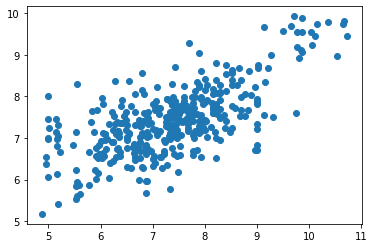

In [58]:
plt.scatter(y_test, y_pred)

#### 일단 우리 모델이 어느정도 잘 작동하는 것 같다! 

#### **그림을 조금 더 예쁘게 그려봅시다.**

#### - 라벨링
#### - 기준선 (y==x) '완벽한 예측의 경우' 를 추가해서 그려보자

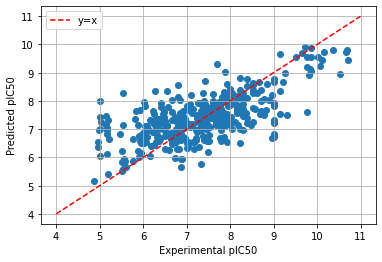

In [60]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")   #plt.plot() 선형 그래프 # x값 4~11, y값 4~11
plt.legend()

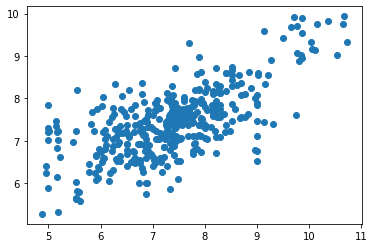

In [21]:
plt.plot(y_test, y_pred, "o")

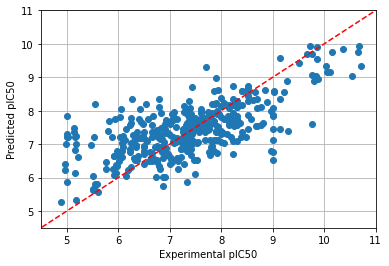

In [29]:
plt.plot(y_test, y_pred, "o")
plt.plot(range(4, 12), range(4, 12), 'r--')
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.xlim(4.5, 11)
plt.ylim(4.5, 11)
plt.grid()

### **오차를 정량화** 해보자!
https://scikit-learn.org/stable/modules/model_evaluation.html

* regression에서 가장 많이 사용하는 측정치는 mean squared error 이다. 
* 평균 제곱 오차 (오차의 제곱을 한 것의 평균값)  
Y : True 값, Y^ : 추정치,예측치

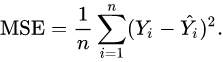

In [61]:
from sklearn.metrics import mean_squared_error

### 오차 계산!

In [65]:
mse1 = mean_squared_error(y_test, y_pred)

In [66]:
import math

In [67]:
math.sqrt(mean_squared_error(y_test, y_pred))  #제곱이니까 다시 루트를 씌우자

0.8457957042367211

In [68]:
mse1

0.7153703733052911

------------------
### ★ Maching Learning 기본 순서 ★
1. 전체 dataset을 불러옴 (데이터를 모음)  
2. traing set / test set으로 나눔
3. 빈 모델을 만듦  **mymodel**=RandomForestRegressor() 
4. 빈 모델에 traing set을 넣어 모델을 학습시킴 .fit(X_train, y_train)  
5. 학습된 모델에 test set을 넣어 예측시켜봄 .predict(X_test)
6. 잘 풀었나 채점해봄 mymodel.metrics.mean_squared_error(y_test, y_pred) 
---
7. **모델 튜닝** Hypter parameter **mymodel2**=RandomForestRegressor(옵션)
8. 어떤 feature가 중요했는지 확인
------------

### ☆더 나은 모델을 만들어보자!

### 트리의 개수를 늘린 모델을 학습시켜보자!
* 옵션주고 → 학습 fit → 예측 predict → 채점 mean_squared_error

In [70]:
my_model_v2 = RandomForestRegressor(n_estimators = 200)

In [71]:
my_model_v2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [72]:
y_pred_v2 = my_model_v2.predict(X_test)

In [73]:
mse2 = mean_squared_error(y_test, y_pred_v2)

In [74]:
print(mse2)

0.6876327646625862


In [75]:
print(mse1, mse2)

0.7153703733052911 0.6876327646625862


#### ↑ 오차가 줄었다! 더 좋은 결과를 얻었다!!
#### ↓ 더 빨간선 근방에 모여있다! 더 좋은 결과를 얻었다!!

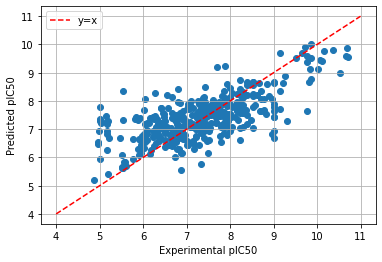

In [76]:
plt.scatter(y_test, y_pred_v2)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()

### Tree 개수 300개에 도전!
* 옵션주고 → 학습 fit → 예측 predict → 채점 mean_squared_error

In [77]:
my_model_v3 = RandomForestRegressor(n_estimators = 300)

In [78]:
my_model_v3.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [81]:
y_pred_v3 = my_model_v3.predict(X_test)

In [82]:
mse3 = mean_squared_error(y_test, y_pred_v3)

In [83]:
print(mse3)

0.6955239649736645


#### ↑ 에러가 조금 증가했다!
* 트리 개수를 늘리는 것이 항상 모델의 정확도를 향상시키지는 않는다!

------------------
### ★ Maching Learning 기본 순서 ★
1. 전체 dataset을 불러옴 (데이터를 모음)
2. traing set / test set으로 나눔
3. 빈 모델을 만듦 
4. 빈 모델에 traing set을 넣어 모델을 학습시킴 
5. 학습된 모델에 test set을 넣어 예측시켜봄 
6. 잘 풀었나 채점해봄 
---
7. 모델 튜닝 Hypter parameter
7. **어떤 feature가 중요했는지 확인** mymodel.featur_importance_
------------

# Feature Importance 확인. 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [84]:
my_model_v3.feature_importances_

array([0.16152455, 0.18441845, 0.09170255, 0.04842652, 0.17622814,
       0.06458474, 0.02623101, 0.19052372, 0.05636031])

* 위 feature importance 결과에서 보면 0.19 값이 가장 크다!
* 8번째 특징이 분자와 JAK2 단백질 사이의 상호작용을 예측하는데 가장 중요한 역할을 한다!

In [85]:
new_data

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings,pIC50
0,367.044919,4.1591,5,1,0.000000,4,4,71.95,4,4.26
1,506.126768,3.6743,10,4,0.083333,7,5,149.78,5,4.34
2,317.173942,1.5361,6,4,0.529412,5,3,101.37,2,4.53
3,301.190260,0.9510,6,5,0.500000,5,3,98.96,2,4.56
4,294.093917,3.2130,4,2,0.062500,2,3,49.84,3,4.59
...,...,...,...,...,...,...,...,...,...,...
1906,350.185509,2.8328,7,2,0.368421,3,4,86.80,3,10.72
1907,541.294742,2.8090,11,2,0.615385,7,5,123.24,3,10.76
1908,421.214761,1.7945,8,2,0.700000,6,4,102.42,0,10.78
1909,358.121195,1.4657,8,2,0.312500,4,4,103.87,3,10.97


* 가장 중요한 성질(8번째 특징): TPSA -> polar surface area. 
* 2번째 중요한 성질: logP
* 3번째 중요한 성질: fraction of SP3 carbon. 
* 4번째 중요한 성질: Molecular weight. 

즉 이 경우 극성을 띤 부분이 Jack2 단백질과 리간드 사이에 상호작용을 결정하는데 중요한 역할을 한다는것을 알 수 있다.